In [105]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import json
import sys

sys.path.append('/home/groups/dpwall/briannac/alt_haplotypes/src/localize')

#from MLE import *

PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/results/simulated_data/kmer_counts.tsv'

In [147]:
from scipy.stats import poisson
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import json


from scipy.stats import poisson
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import json

def GlobalInterval(L, prob_thresh=.95):
    print('global babay')
    '''
        Returns the tightest genomic region where the probability of a k-mer occuring is at least prob_thresh, given the likelihoods L at each region.
                Parameters:
                        L (array): Array of likelihoods for each global genomic region.
                        prob_thresh (float): Minimum probability that a set of genomic regions contains a k-mer.

                Returns:
                        interval (tuple): The start and end idxs of the tightest global genomic region where the probability of a k-mer residing is at least prob_thresh.
        '''    
    
    P = 2**(L-max(L))
    P = P/sum(P)
    cumsum = np.cumsum(P)
    smallest_end = np.where(cumsum>prob_thresh)[0][0]
    cumsum = np.cumsum(P[::-1])[::-1]
    largest_start = np.where(cumsum>prob_thresh)[0][-1]

    shortest_segment = min(smallest_end, len(P)-largest_start)
    interval = (np.nan,np.nan)
    for start in [s for s in range(largest_start)][::-1]:
        for end in range(smallest_end, start+shortest_segment):
            if (sum(P[start:end])>prob_thresh) & ((end-start)<shortest_segment):
                shortest_segment = end-start
                interval = (start,end)
                prob = sum(P[start:end])
                break
        if (smallest_end-start)>=shortest_segment: break
    return (start, end)




class MLE:
    def __init__(self, avg_kmer_depth, poisson_cache_length, eps=0):
        print('initializing')
        self.poisson_cache = [[], []]
        self.avg_kmer_depth=avg_kmer_depth
        self.poisson_cache[0] = [poisson.pmf(k=k, mu=avg_kmer_depth) for k in range(poisson_cache_length)]
        self.poisson_cache[1] = [poisson.pmf(k=k, mu=2*avg_kmer_depth) for k in range(poisson_cache_length)]
        self.cached_family_log_likelihood = dict()
        self.eps = eps
        
        
        
        
        
    def cached_poisson_pmf(self,k,g):
        if (g==0) & (k!=0):
            return self.eps
        if (k==0) & (g==0): 
            return 1-3*self.eps #poisson.pmf(g*avg_kmer_depth, k)
        else:
            return min(max(self.poisson_cache[g-1][k], self.eps), 1-3*self.eps)
    
    
    
    
    
    def family_log_likelihood(self,k_m, k_p, k_cs, phases_ch):

        '''
        Returns the probability of a k-mer distribution in a family given the each member's kmer counts and the children's phasings. Note: takes about 1 second per 50K family-regions.

                Parameters:
                        k_m (int): mom_kmer_count (int): A decimal integer
                        k_p (int): dad_kmer_count (int): Another decimal integer
                        phases_ch (list): A list of of tuples representing each child's phasings (mom's chromome, dad's chromosme) {(0,0), (0,1), (1,0), (1,1)}
                        avg_kmer_depth (int): Mean for avg k-mer depth of poisson distribution.

                Returns:
                        log likelihood (float): The log of the probability of the family's k-mer distribution given the famiy genotypes.
        '''    

        key = tuple(sorted([(k_m, k_p, k,g[0], g[1]) for k,g in zip(k_cs, phases_ch)]))
        if key in self.cached_family_log_likelihood: log_P = self.cached_family_log_likelihood[key]
        else:
            possible_gs = [(0,0), (1,1), (0,1), (1,0)]
            log_P_m = np.log2(sum([self.cached_poisson_pmf(k_m, g) for g in [0,1,1,2]]))
            log_P_p= np.log2(sum([self.cached_poisson_pmf(k_p, g) for g in [0,1,1,2]]))
            log_P_ch = np.log2(sum([self.cached_poisson_pmf(k_m,sum(g_m))*self.cached_poisson_pmf(k_p,sum(g_p))*
                                    np.prod([self.cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) 
                                             for k_c, phase_ch in zip(k_cs, phases_ch)]) for g_p in possible_gs for g_m in possible_gs]))
            log_P = log_P_ch-log_P_m-log_P_p
            self.cached_family_log_likelihood[key] = log_P

            if log_P>0: print("ERROR: log likelihood cannot be > 0")
        return log_P
    
    
    
    
    
    def GlobalLikelihood(self,kmer_counts, bam_mappings, family_info, global_region_to_idx, fam_region_to_idx, fam_idx_to_global_idx, MAX_FAMS=100):
        final_likelihoods = {}
        families_in_file = [i.replace('.txt', '').split('/')[-1] for i in glob(
            '/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/*.txt')]
        sample_id_to_participant = {sample_id:participant_id for participant_id, sample_id in zip(bam_mappings.participant_id, bam_mappings.index)}
        for k in kmer_counts.iterrows():
            print(k[0])
            global_likelihoods = [] #np.zeros(len(global_region_to_idx)) 
            fams_included = set(bam_mappings.loc[kmer_counts.columns[k[1]>0]].family).intersection(family_info.index).intersection(families_in_file)
            for fam in (list(fams_included)[:MAX_FAMS]):  
                global_likelihood = np.zeros(len(global_region_to_idx)) 


                # Extract mom, dad, and child sample_ids.
                children = family_info.loc[fam].sib_samples
                mom = family_info.loc[fam].mother_sample
                dad = family_info.loc[fam].father_sample
                phased_fam = pd.read_csv('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/%s.txt' % fam,
                                         sep='\t')

                # Skip family if dataframe is weird.
                missing_children=False
                for ch in children:
                    if sample_id_to_participant[ch] + '_mat' not in phased_fam.columns: 
                        missing_children=True
                        break
                if missing_children: continue
                
                # Set up phasing dataframe.
                for ch in children:
                    phased_fam[ch] = [(m,d-2) for m,d in zip(phased_fam[sample_id_to_participant[ch]+'_mat'], phased_fam[sample_id_to_participant[ch]+'_pat'])]
                phased_fam.index = ['%s.%09d.%09d' % (('0' + chrom[3:])[-2:].replace('0X', 'XX'), start, end) for chrom, start, end in phased_fam[['chrom', 'start_pos', 'end_pos']].values]
                #phased_fam = phased_fam[children]

                # Compute family likelihood.
                fam_likelihood = [self.family_log_likelihood(k[1][mom], k[1][dad], k[1][children], phased_fam[children].iloc[i]) for i in range(len(phased_fam))]

                # Convert family likelihood region to global region. 
                for i,l in enumerate(fam_likelihood):
                    global_idxs = fam_idx_to_global_idx[fam_region_to_idx[phased_fam.index[i]]]
                    global_likelihood[global_idxs] =  l
                global_likelihood[global_likelihood==0] = np.median(global_likelihood[global_likelihood!=0])
                global_likelihoods = global_likelihoods + [global_likelihood]

            final_likelihoods[k[0]] = np.array(global_likelihoods).sum(axis=0)
            #try:
            #    print(GlobalInterval(final_likelihoods[k[0]]))
            #except: donothing=True
            #print([idx_to_global_region[i] for i in np.argsort(final_likelihood)[::-1][:100:10]])
        return final_likelihoods



In [5]:
# Load in family region/global region conversion data.
fam_region_to_idx = np.load(PHASINGS_DIR +  'fam_region_to_idx.npy', allow_pickle=True).item()
idx_to_fam_region = np.load(PHASINGS_DIR +  'idx_to_fam_region.npy', allow_pickle=True).item()
global_region_to_idx = np.load(PHASINGS_DIR +  'global_region_to_idx.npy', allow_pickle=True).item()
idx_to_global_region = np.load(PHASINGS_DIR +  'idx_to_global_region.npy', allow_pickle=True).item()
fam_idx_to_global_idx = np.load(PHASINGS_DIR + 'fam_regions_to_global_regions.npy', allow_pickle=True)
family_info = pd.read_pickle(PHASINGS_DIR + 'fam_list.df')

# Info from BAM mappings.
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']


# Load simulated k-mer counts.

In [63]:
kmer_counts = pd.read_table(KMER_COUNTS_FILE, index_col=0)
kmer_counts = kmer_counts[((kmer_counts>0).mean(axis=1)>.05) & ((kmer_counts>0).mean(axis=1)<.5)]
kmer_counts.index = [(int(i.split(',')[0].replace('(', '')), float(i.split(',')[1].replace(')', ''))) for i in kmer_counts.index]

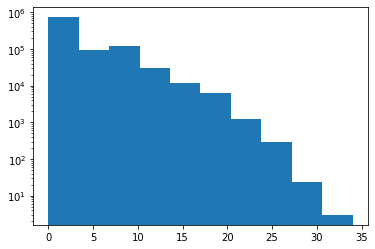

In [64]:
plt.hist(kmer_counts.iloc[:1000].values.flatten())
plt.yscale('log')

In [65]:
kmer_counts[kmer_counts==0]=np.nan
plt.hist(np.nanmean(kmer_counts, axis=1))

(array([13., 27., 38., 41., 36., 46., 44., 28., 18., 10.]),
 array([7.00293255, 7.15044115, 7.29794976, 7.44545836, 7.59296696,
        7.74047556, 7.88798417, 8.03549277, 8.18300137, 8.33050997,
        8.47801858]),
 <BarContainer object of 10 artists>)

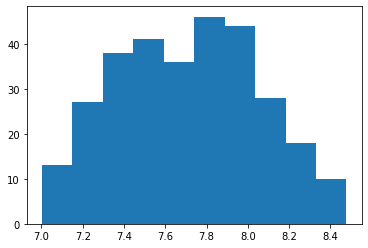

In [67]:
plt.hist(np.nanmean(kmer_counts, axis=1))

# Ground Truth Kmers

In [85]:
# Load in k-mer counts.
KMERS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/ground_truth/sample_kmer_matrix/known_alt_haplotype_kmers_filt.txt'
KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/ground_truth/sample_kmer_matrix/kmers.filt.tsv'

kmer_counts = pd.read_table(KMER_COUNTS_FILE, header=None, index_col=0, nrows=10000, skiprows=100000)
kmer_names = pd.read_table(KMERS_FILE, header=None, index_col=0, nrows=10000, skiprows=100000)
kmer_counts.index = [(i,j) for i,j in zip(kmer_names.index, kmer_names[1])]
kmer_counts.columns = bam_mappings.index
kmer_counts = kmer_counts[((kmer_counts>0).mean(axis=1)>.05) & ((kmer_counts>0).mean(axis=1)<.5)]
#kmer_names = kmer_names.loc[kmer_counts.index]

(array([2., 3., 1., 1., 1., 1., 1., 0., 1., 1.]),
 array([5.11496746, 5.14847072, 5.18197397, 5.21547722, 5.24898048,
        5.28248373, 5.31598698, 5.34949024, 5.38299349, 5.41649675,
        5.45      ]),
 <BarContainer object of 10 artists>)

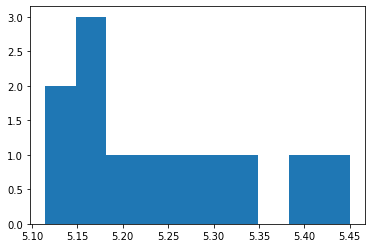

In [165]:
kmer_counts_filt = kmer_counts[1000:1012].copy()
kmer_counts_filt[kmer_counts_filt==0]=np.nan
plt.hist(np.nanmean(kmer_counts_filt, axis=1))

In [8]:
ref_genome = {r.id:r.description for r in SeqIO.parse(
    '/home/groups/dpwall/briannac/general_data/reference_genomes/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa', 'fasta')}

In [33]:
ref_genome[kmer_counts.index[0][1]]

'chr1_KI270762v1_alt  AC:KI270762.1  gi:568335926  LN:354444  rg:chr1:2448811-2791270  rl:alt-scaffold  M5:b0397179e5a92bb7a3300b68e45a9f72  AS:GRCh38'

In [174]:
set([i[1] for i in kmer_counts.index[::500]])

{'chr3_GL383526v1_alt', 'chr3_KI270778v1_alt', 'chr3_KI270781v1_alt'}

In [175]:
len(kmer_counts.index[::500])

6

# Load phasings/haplotype information

In [176]:
mle = MLE(5.5, 100, eps=0)
a = mle.GlobalLikelihood(kmer_counts.iloc[::500], bam_mappings, family_info,
                         global_region_to_idx, fam_region_to_idx, fam_idx_to_global_idx, MAX_FAMS=100)

initializing
('CCTCCTTTCTCAGCAGTGAGGAGGTCTAGGCCTCGGCGGTTTTGAAGAGTCACTGCTGCCAAAGAGTCTAATTGGGATTGTAAAGTAAGGATAGATTTTG', 'chr3_GL383526v1_alt')
('CGCTTGAACCTGGAAGGCGGAGGTTGCACTGAGCAGAGATCGTGCCATTGCCAGCCTGGGCAACAAGAGTGAAACTTCGTCTCAAAAAAAAAAAAAAAAA', 'chr3_KI270778v1_alt')
('TACTAATATTTTACTTTTTATAAAATATAATAAGCTGTTCCTTATATTTTGTTATGTCATTGAAAAGTTTGAGTTTATGTATCACCAGCCTAAATTATTC', 'chr3_KI270778v1_alt')
('CTGAAAGCACCACTACAGATTCTCCAAAGTTTTAAAATTTTGCATATGCTAGGAATTTGAGTAGACATATTGCAAAATCATATTCCATATAGAAGAACCA', 'chr3_KI270778v1_alt')
('CTCATCAAATTTAACACATTTGGTGGAATCTTTCAAAAATAAAACAGAACAAAGCAAAAATAGGCAGGCAGAGCAGGTGTTGGCATGTTAAACTTTTCCA', 'chr3_KI270778v1_alt')
('TGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTATAAAATATGTGTATATATATTATATGTATATATTTAAATATATATTATATGTATATATTTAAAGAT', 'chr3_KI270781v1_alt')


In [156]:
def GlobalInterval(L, prob_thresh=.95):
    '''
        Returns the tightest genomic region where the probability of a k-mer occuring is at least prob_thresh, given the likelihoods L at each region.
                Parameters:
                        L (array): Array of likelihoods for each global genomic region.
                        prob_thresh (float): Minimum probability that a set of genomic regions contains a k-mer.

                Returns:
                        interval (tuple): The start and end idxs of the tightest global genomic region where the probability of a k-mer residing is at least prob_thresh.
        '''    
    
    P = 2**(L-max(L))
    P = P/sum(P)
    cumsum = np.cumsum(P)
    smallest_end = np.where(cumsum>prob_thresh)[0][0]
    cumsum = np.cumsum(P[::-1])[::-1]
    largest_start = np.where(cumsum>prob_thresh)[0][-1]

    shortest_segment = min(smallest_end, len(P)-largest_start)
    interval = (np.nan,np.nan)
    for start in [s for s in range(largest_start)][::-1]:
        for end in range(smallest_end, start+shortest_segment):
            if (sum(P[start:end])>prob_thresh) & ((end-start)<shortest_segment):
                shortest_segment = end-start
                interval = (start,end)
                prob = sum(P[start:end])
                break
        if (smallest_end-start)>=shortest_segment: break
    return (start, end)

true location:  chr3:151589366-151759498 MLE prediction:  03.153693244.153693245-03.155083482.155083576
true location:  chr3:166300784-166544173 MLE prediction:  03.156516550.156519356-03.167797708.167799060
true location:  chr3:166300784-166544173 MLE prediction:  03.165302424.165318566-03.167479269.167500375
true location:  chr3:166300784-166544173 MLE prediction:  03.164652044.164660248-03.167446626.167479269
true location:  chr3:166300784-166544173 MLE prediction:  03.164660248.164660671-03.167446626.167479269
true location:  chr3:184425340-184533338 MLE prediction:  03.184351867.184372478-03.184466254.184489584


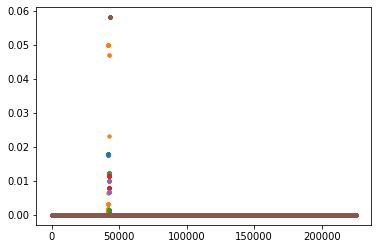

In [186]:
for i in range(len(a)):
    L =list(a.values())[i]
    P = 2**(L-max(L))
    plt.plot(P/sum(P), '.')
    start, end = GlobalInterval(L, .95)
    print('true location: ', ref_genome[list(a.keys())[i][1]].split('  ')[4].replace('rg:', ''),
          'MLE prediction: ', idx_to_global_region[start] + '-' + idx_to_global_region[end])

In [94]:
def GlobalInterval(L, prob_thresh=.95):
    print('global babay')
    '''
        Returns the tightest genomic region where the probability of a k-mer occuring is at least prob_thresh, given the likelihoods L at each region.
                Parameters:
                        L (array): Array of likelihoods for each global genomic region.
                        prob_thresh (float): Minimum probability that a set of genomic regions contains a k-mer.

                Returns:
                        interval (tuple): The start and end idxs of the tightest global genomic region where the probability of a k-mer residing is at least prob_thresh.
        '''    
    
    P = 2**(L-max(L))
    P = P/sum(P)
    cumsum = np.cumsum(P)
    smallest_end = np.where(cumsum>prob_thresh)[0][0]
    cumsum = np.cumsum(P[::-1])[::-1]
    largest_start = np.where(cumsum>prob_thresh)[0][-1]

    shortest_segment = min(smallest_end, len(P)-largest_start)
    interval = (np.nan,np.nan)
    for start in [s for s in range(largest_start)][::-1]:
        for end in range(smallest_end, start+shortest_segment):
            if (sum(P[start:end])>prob_thresh) & ((end-start)<shortest_segment):
                shortest_segment = end-start
                interval = (start,end)
                prob = sum(P[start:end])
                break
        if (smallest_end-start)>=shortest_segment: break
    return (start, end)

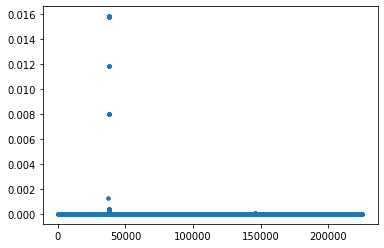

In [149]:
L =list(a.values())[0]
P = 2**(L-max(L))
plt.plot(P/sum(P), '.')


In [150]:
start, end = GlobalInterval(L, .95)
print(ref_genome[list(a.keys())[0][1]])
print(idx_to_global_region[start], idx_to_global_region[end])

global babay
37546 37704


In [151]:
idx_to_global_region[start], idx_to_global_region[end]

('03.074420335.074427723', '03.075634544.075663659')

In [145]:
ref_genome[list(a.keys())[0][1]]

'chr3_GL383526v1_alt  AC:GL383526.1  gi:302201752  LN:180671  rg:chr3:151589366-151759498  rl:alt-scaffold  M5:620913159e2fbd4e931ac120e3c584c9  AS:GRCh38'

(12995, 0.12255943984653905)


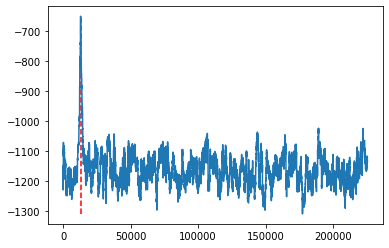

In [119]:
idx = 1
key = list(global_likelihoods.keys())[idx]
L = global_likelihoods[key]
plt.vlines(x=key[0], ymin=min(L), ymax=max(L), color='red', linestyle='dashed')
print(key)
plt.plot(L)